# Project: Exploring Cook County Housing
## Introduction
The following project explores what can be learned from an extensive housing dataset that is embedded in a dense social context in Cook County, Illinois.

At first, I will perform some basic Exploratory Data Analysis (EDA) to understand the structure of the data. Next, I will be adding a few new features to the dataset, while cleaning the data as well in the process.

As the next part, I will specify and fit a linear model for the purpose of prediction. Finally, I will analyze the error of the model and brainstorm ways to improve the model's performance.

In [1]:
import numpy as np
import pandas as pd

from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

<hr style="border: 5px solid #003262;" />

# The Data

The dataset consists of over 500,000 records from Cook County, Illinois. The dataset has 61 features in total; the 62nd is `Sale Price`, which I will predict with linear regression. An explanation of each variable can be found in the included `codebook.txt` file.

The data are split into training and test sets with 204,792 and 68,264 observations, respectively.

Let's load the training data.

In [2]:
training_data = pd.read_csv("cook_county_train.csv", index_col = 'Unnamed: 0')

As a good sanity check, I will verify that the data shape matches the description.

In [3]:
# 204,792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

The next order of business is getting a feel for the variables in my data.  A more detailed description of each variable is included in `codebook.txt` (in the same directory as this notebook).

Let's take a quick look at all the current columns in our training data.

In [4]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [5]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

<hr style="border: 1px solid #fdb515;" />

# Contextualizing the Data

Let's try to understand the background of my dataset before diving into a full-scale analysis. 

The granularity of this dataset is a single property in Cook County with all of its different characteristics as column values. 

I think that this data could be collected for such a reason as to create a model that predicts house prices based on the given characteristics. It could be that some real estate type of a company collected this data to set reasonable prices for new houses that they'll sell/buy.

If I could add more information about each house in Cook County, I would want to study the relationship of annual income with the respective house price. To do so, I would create a scatterplot of these two variables.

<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis

This dataset was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home. You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf). In the second part of this project, I will be building a linear regression model that predicts sales prices using training data, but it's important to first understand how the structure of the data informs such a model. With that said, I will make a series of exploratory visualizations and feature engineering in preparation for that prediction part.

In the following, I will perform EDA on the **training data**.

### Sale Price
I'll begin by examining the distribution of my target variable `Sale Price`. I created the following helper method `plot_distribution` that I can use to visualize the distribution of the `Sale Price` using both the histogram and the box plot at the same time.

In [6]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

/var/folders/53/6bk9szg91vg4209h0xj26_500000gp/T/ipykernel_55106/41219570.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


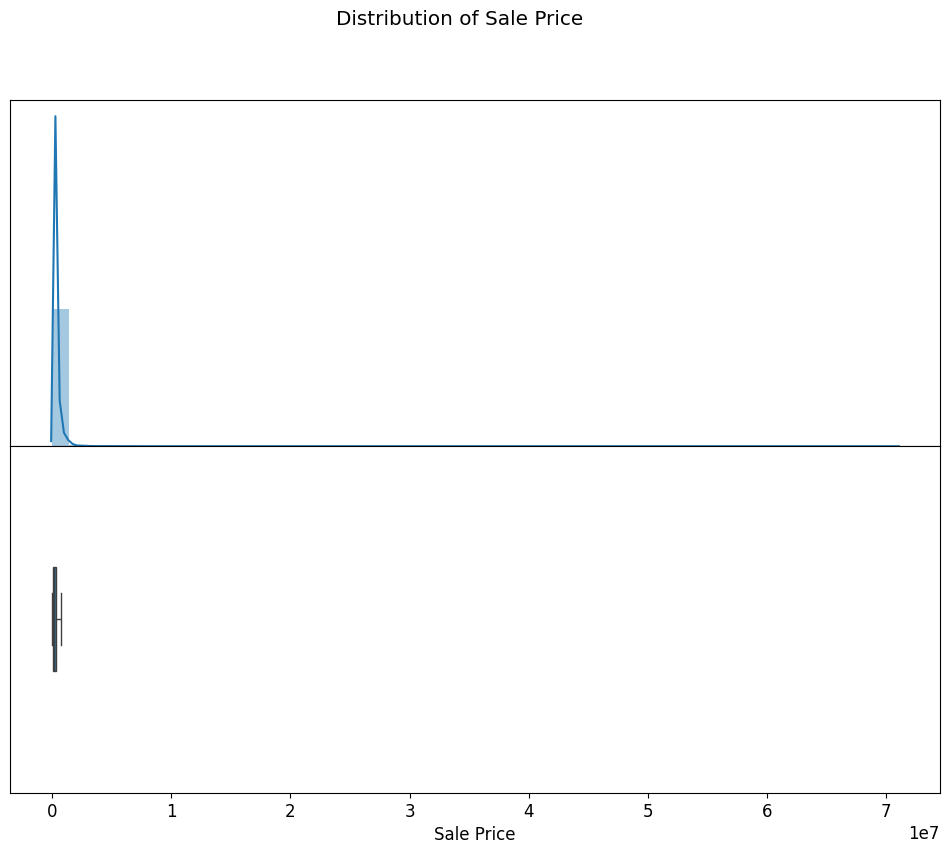

In [7]:
plot_distribution(training_data, label='Sale Price')

To zoom in on the visualization of most households, I will focus only on a subset of `Sale Price` for this part. In addition, it may be a good idea to apply log transformation to `Sale Price`.

- `training_data` is now limited with households whose price is at least $500.
- `training_data` now contains a new `Log Sale Price` column that has the log-transformed sale prices.

**Note**: This also implies from now on, my target variable in the model will be the log-transformed sale prices from the column `Log Sale Price`. 

In [8]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

Let's create a new distribution plot on the log-transformed sale price. We should now see that the distribution for the Log Scale Price is much more uniform.

/var/folders/53/6bk9szg91vg4209h0xj26_500000gp/T/ipykernel_55106/41219570.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


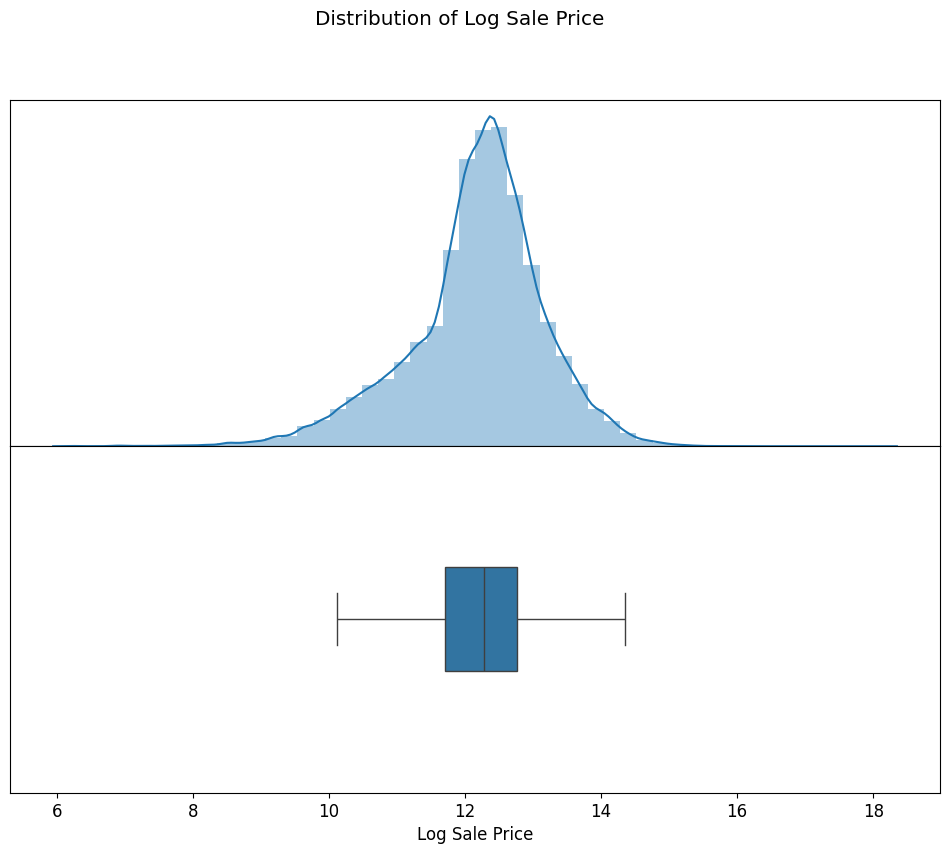

In [9]:
plot_distribution(training_data, label='Log Sale Price');

Next, I want to explore if there is any correlation between `Log Sale Price` and the total area occupied by the property. The `codebook.txt` file tells us the column `Building Square Feet` should do the trick -- it measures "(from the exterior) the total area, in square feet, occupied by the building".

Let's also apply a log transformation to the `Building Square Feet` column.

In [10]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

Continuing from the previous part, as we explore the dataset, we might still run into more outliers that prevent us from creating a clear visualization or capturing the trend of the majority of the houses. 

In the following, I will work to remove these outliers from the data as we run into them by writing a function `remove_outliers` that removes outliers from the dataset based off a threshold value of a variable. For example, `remove_outliers(training_data, 'Building Square Feet', lower=500, upper=8000)` should return a copy of `data` with only observations that satisfy `Building Square Feet` less than or equal to 8000 (inclusive) and `Building Square Feet` greater than 500 (exclusive).

In [11]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    new = data.copy()
    new = new[(new[variable] > lower) & (new[variable] <= upper)]
    return new

<hr style="border: 1px solid #fdb515;" />

# Part 3: Feature Engineering

In this section, I will perform a few feature engineering techniques. 

### Bedrooms

Let's start simple by extracting the total number of bedrooms as a first feature for the model. You may notice that the `Bedrooms` column doesn't actually exist in the original `DataFrame`! Instead, it is part of the `Description` column.

Let's take a closer look at the `Description` column before going anywhere. By just using the description column values, we can get the following data about each property.

1. The date the property was sold on.
2. The number of stories the property contains.
3. The address of the property.
4. The total number of rooms inside the property.
5. The total number of bedrooms inside the property.
6. The total number of bathrooms inside the property.

I'll create a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the total number of bedrooms (**as integers**) for each house. 

In [12]:
import re
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bedrooms" containing ints.

    """
    with_rooms = data.copy()
    pattern = r'rooms, (\d+)'
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(pattern).astype(int)
    return with_rooms

training_data = add_total_bedrooms(training_data)

Let's create a visualization that clearly and succinctly shows if there exists an association between  `Bedrooms` and `Log Sale Price`. A good visualization should satisfy the following requirements:

Text(0.5, 0, '# of bedrooms')

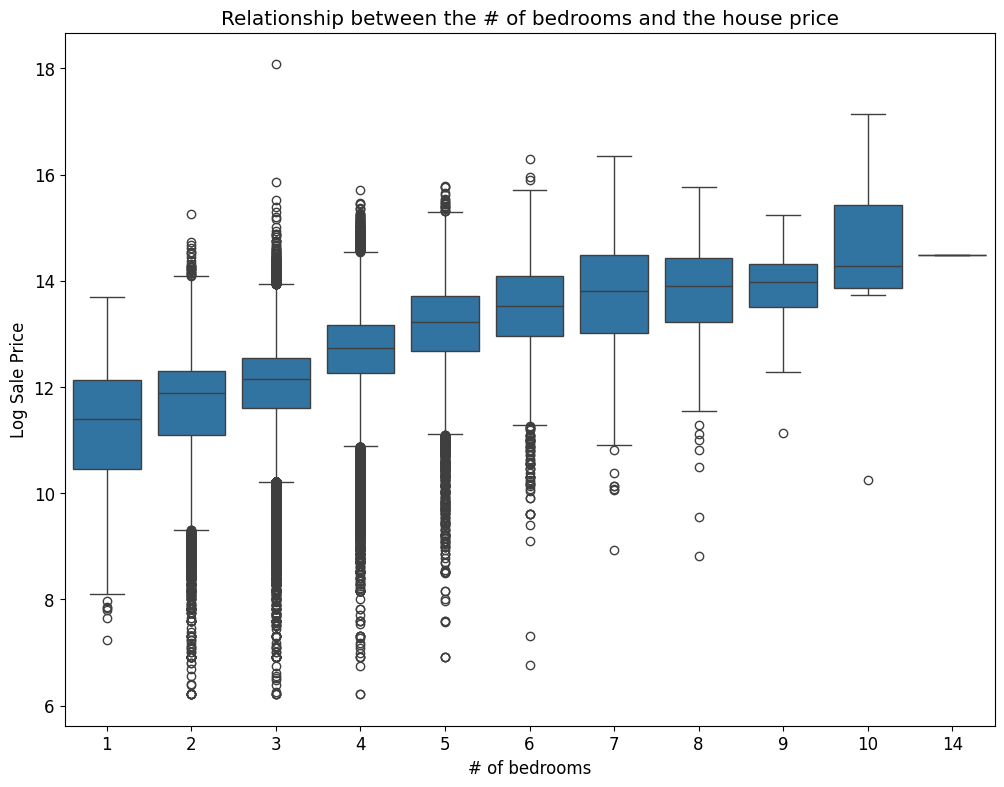

In [13]:
sns.boxplot(data = training_data, x = 'Bedrooms', y = 'Log Sale Price')
plt.title('Relationship between the # of bedrooms and the house price')
plt.xlabel('# of bedrooms')

In [14]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

In [15]:
top_20_neighborhood_codes = training_data['Neighborhood Code'].value_counts().index[:20]
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_20_neighborhood_codes)]

/var/folders/53/6bk9szg91vg4209h0xj26_500000gp/T/ipykernel_55106/2599663924.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)


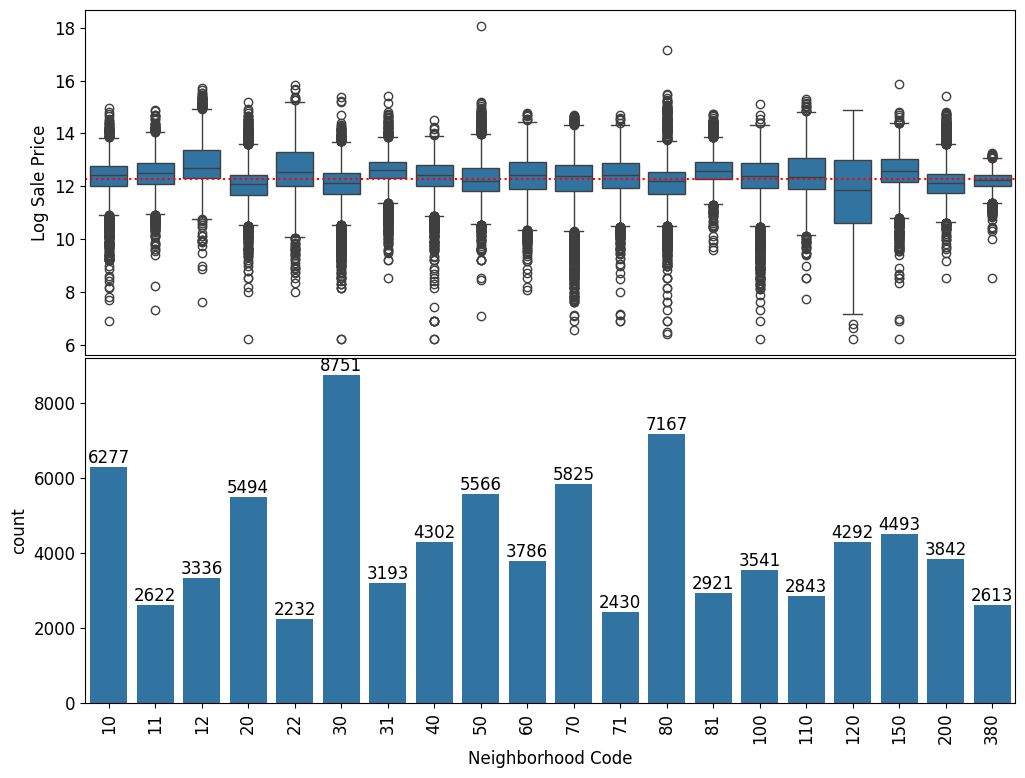

In [16]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

If we look at `codebook.txt` carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Roof Material (Nominal): 

       1    Shingle/Asphalt
       2    Tar & Gravel
       3    Slate
       4    Shake
       5    Tile
       6    Other
```

I want to write a function `substitute_roof_material` that replaces each numerical value in `Roof Material` with their corresponding roof material.

In [17]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    dict = {1: 'Shingle/Asphalt', 2: 'Tar & Gravel', 3: 'Slate', 4: 'Shake', 5: 'Tile', 6: 'Other'}
    data.replace(to_replace = dict, inplace = True)
    return data
    
training_data_mapped = substitute_roof_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms
1,13272240180000,202,120,3780.0,71,0.0,Tar & Gravel,Shingle/Asphalt,Shingle/Asphalt,Shingle/Asphalt,...,9.6,Shingle/Asphalt,Shingle/Asphalt,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,Slate
2,25221150230000,202,210,4375.0,70,0.0,Tar & Gravel,Shingle/Asphalt,Tar & Gravel,Slate,...,11.2,Shingle/Asphalt,Shingle/Asphalt,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,Slate
3,10251130030000,203,220,4375.0,17,0.0,Slate,Shingle/Asphalt,Shingle/Asphalt,Slate,...,6.3,Shingle/Asphalt,Shingle/Asphalt,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,Slate
4,31361040550000,202,120,8400.0,32,0.0,Slate,Shingle/Asphalt,Tar & Gravel,Slate,...,6.3,Shingle/Asphalt,Shingle/Asphalt,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,Tar & Gravel
6,30314240080000,203,181,10890.0,37,0.0,Shingle/Asphalt,Shingle/Asphalt,Shingle/Asphalt,Slate,...,10.9,Shingle/Asphalt,Shingle/Asphalt,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,Shake


Unfortunately, simply replacing the integers with the appropriate strings isn’t sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data.

I will create a function `ohe_roof_material` that returns a `DataFrame` with the new column one-hot-encoded on the roof material of the household. These new columns should have the form `Roof Material_MATERIAL`.

In [18]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    ohe = OneHotEncoder()
    data1 = data.copy()
    ohe.fit(data[['Roof Material']])
    encoded_roof = ohe.transform(data[['Roof Material']]).toarray()
    data1 = data1.join(pd.DataFrame(encoded_roof, columns = ohe.get_feature_names_out(), index = data1.index))
    return data1
    

training_data_ohe = ohe_roof_material(training_data_mapped)
# This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar & Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


<hr style="border: 1px solid #fdb515;" />

### What's next?
In the following part of the project, I will focus on building a linear regression model to predict house prices. I'm pretty well-prepared to build such a model as I have considered what is in this dataset, what it can be used for, and engineered some features that should be useful for prediction.

Specifically, I will fit a linear model to a few features of the housing data to predict house prices. Next, I will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, I'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties.

<hr style="border: 1px solid #fdb515;" />

The dataset is split into a training/validation set and a testing set. Importantly, the test set does not contain values for our target variable, `Sale Price`. In this project, I will train a model on the training/validation set then use this model to predict the `Sale Price`s of the test set. In the cell below, I load the training/validation set into the `DataFrame` `training_val_data` and the test set into the `DataFrame` `test_data`.

In [21]:
training_val_data = pd.read_csv("cook_county_train.csv", index_col = 'Unnamed: 0')
test_data = pd.read_csv("cook_county_test.csv", index_col = 'Unnamed: 0')

In [23]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<hr style="border: 1px solid #fdb515;" />

## Preparing Data


Let's split the dataset into a training set and a validation set. We will use the training set to fit our model's parameters and the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

The following function `train_val_split`  splits `data` into two smaller `DataFrame`s named `train` and `validation`. `train` contains 80% of the data, and `validation` contains the remaining 20%.

In [24]:
def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indices, validation_indices = shuffled_indices[:int(0.8 * data_len)], shuffled_indices[int(0.8 * data_len):]
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

<hr style="border: 1px solid #fdb515;" />

## Evaluating The Simple Model

<br>

--- 

When we get to analyzing models' performance, I'll be using the following function that computes the Root Mean Squared Error (RMSE).

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$

The function is provided below.

In [25]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))


---

## Defining Pipeline Funtion

Just as in the guided model from the previous question, we should encapsulate as much of our workflow into functions as possible. Our job is to select better features and define our own feature engineering pipeline inside the function `process_data_final` in the following cell.

- Any feature engineering techniques that involve referencing `Sale Price` (for example, removing outlying `Sale Price` values from the training data) will be performed under the condition `if not is_test_set:`
- All other feature engineering techniques will be applied to both the training and test sets. This means that I will perform them under the condition `else:`
- When `is_test_set` is `True`, my function should return only the design matrix, `X`.
- When `is_test_set` is `False`, my function should return both the design matrix and the response variable `Y` (the `Log Sale Price` column).

In [26]:
def process_data_final(data, is_test_set=False):
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        data = remove_outliers(data, 'Building Square Feet', lower = 500, upper = 8000)
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
  
        data = remove_outliers(data, 'Sale Price', lower = 150, upper = 65000000)
        data['Log Sale Price'] = np.log(data['Sale Price'])
        
        data = remove_outliers(data, 'Estimate (Land)', lower = 4000, upper = 1000000)
        data['Log Estimate (Land)'] = np.log(data['Estimate (Land)'])
        
        data = remove_outliers(data, 'Land Square Feet', lower = 150, upper = 730000)
        data['Log Land Square Feet'] = np.log(data['Land Square Feet'])

    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        data['Estimate (Land)'] += 1
        data['Land Square Feet'] += 1
        data['Building Square Feet'] += 1
        
        data['Log Estimate (Land)'] = np.log(data['Estimate (Land)'])
        data['Log Land Square Feet'] = np.log(data['Land Square Feet'])
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])

    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    data = add_total_bedrooms(data)
    #data = total_bathrooms(data)
    #data = total_story(data)
    #data = ohe_stories(data)
    
    
    # Return predictors (X) and response (Y) variables separately
    if is_test_set:
        # Predictors
        X = data[['Log Estimate (Land)', 'Log Building Square Feet', 'Log Land Square Feet', 'Bedrooms']]
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        X = data[['Log Estimate (Land)', 'Log Building Square Feet', 'Log Land Square Feet', 'Bedrooms']]
        # Response variable
        Y = data['Log Sale Price']
        
        return X, Y

In [27]:
def rmse_interval(X, Y, start, end):
    '''
    Given a design matrix X and response vector Y, computes the RMSE for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval (start, end).

    Input: 
    X - 2D DataFrame representing the design matrix.
    Y - 1D DataFrame consisting of a single column labeled 'Log Sale Price'.
    start - A float specifying the start of the interval (exclusive).
    end - A float specifying the end of the interval (exclusive).
    '''
    Y = pd.DataFrame(Y)

    Y_subset = Y[(Y['Log Sale Price'] > start) & (Y['Log Sale Price'] < end)]['Log Sale Price']
    X_subset = X.loc[Y_subset.index]

    # DO NOT MODIFY THESE TWO LINES
    if len(X_subset) == 0:
        return 0
        
    rmse_subset = rmse(np.exp(model.predict(X_subset)), Y_subset)
    return rmse_subset
    
def prop_overest_interval(X, Y, start, end):
    '''
    Given a design matrix X and response vector Y, computes prop_overest for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval (start, end).

    Input: 
    X - 2D DataFrame representing the design matrix.
    Y - 1D DataFrame consisting of a single column labeled 'Log Sale Price'.
    start - A float specifying the start of the interval (exclusive).
    end - A float specifying the end of the interval (exclusive).
    '''
    Y = pd.DataFrame(Y)
    
    Y_subset = Y[(Y['Log Sale Price'] > start) & (Y['Log Sale Price'] < end)]['Log Sale Price']
    X_subset = X.loc[Y_subset.index]

    # DO NOT MODIFY THESE TWO LINES
    if len(X_subset) == 0:
        return 0
    
    prop_subset = sum(np.exp(model.predict(X_subset)) > np.exp(Y_subset)) / len(Y_subset)
    return prop_subset